# Exploratory Data Analysis

This section describes the findings from the exploratory data analysis phase.

### Part 1. Examining Data Completeness by Year###

The distribution of the number of years within an MSA (Figure 1) shows that close to 75% of the MSAs have data for all 11 years. We also compared the distributions of all features for MSAs that have all 11 years vs the ones that don't (Figure 2). The distributions look very similar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

Total # of MSAs: 392


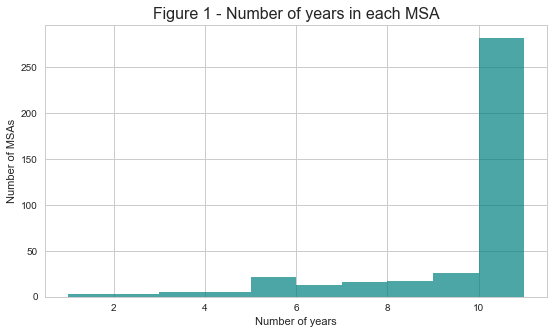

In [2]:
# Load in final dataframe without imputed values
final_df = pd.read_json("output/final.json")
print("Total # of MSAs: %i" %len(final_df['join_key'].unique()))
#Plot a histogram by number of years
fig, ax = plt.subplots(1,1, figsize=(9,5))
final_df['num_years'] = final_df.groupby('join_key')['year'].transform(len)
groups = final_df.loc[:, ['join_key', 'num_years']].drop_duplicates()
ax.hist(groups['num_years'], color='teal', alpha=0.7)
ax.set_title('Figure 1 - Number of years in each MSA',fontsize=16)
ax.set_xlabel('Number of years')
ax.set_ylabel('Number of MSAs');

# Consider only MSAs with all 11 years of data
full_msa = final_df.num_years == 11

In [3]:
# Quick to look at differences between full MSA and non
def compare_msa(var, ax, max_value):
    ax.hist(final_df.loc[full_msa, var], range=(0, max_value), alpha=0.5, label='11')
    ax.hist(final_df.loc[~full_msa, var], range=(0, max_value), alpha=0.5, label='<11')
    ax.set_title("%s Histogram" %var)
    ax.legend();

Figure 2 - Distribution Comparisons - MSAs with 11 years vs MSAs without 11 years


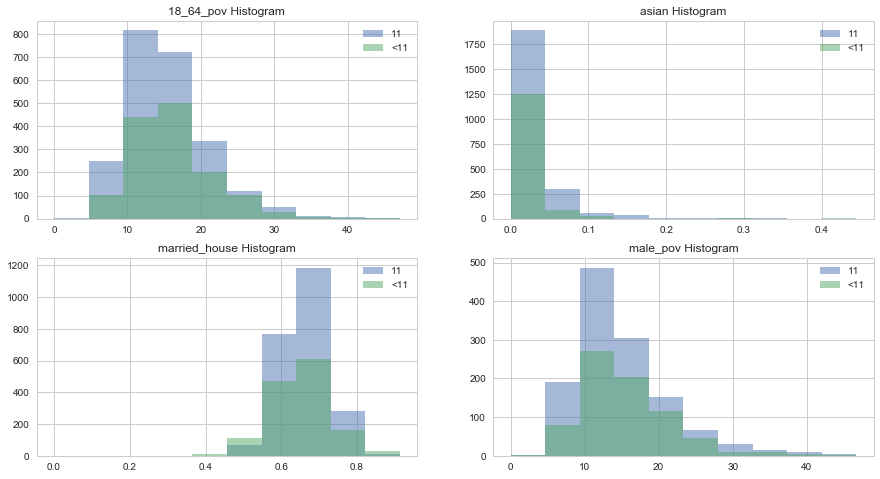

In [4]:
# Look at Differences for MSA that have all years and ones that do not
fig, ax = plt.subplots(2,2, figsize=(15,8))
ax = ax.flatten()

graph_vars = [v for v in final_df.columns 
              if "state_" not in v and "MSA_" not in v and 'year' not in v]
graph_vars = ['18_64_pov','asian','married_house','male_pov']

for i, v in enumerate(graph_vars):
    if v not in ['city_key', 'MSA', 'state_key', 'join_key', 'largest_city']:
        compare_msa(v, ax[i], final_df.loc[:, v].max())
print('Figure 2 - Distribution Comparisons - MSAs with 11 years vs MSAs without 11 years')

We also examined the distribution of states between MSA with full years against MSAs with 11 than 11 years of data.  Based on the plots in Figure 3 there is no clear sytematic difference between those that have 11 and those that do not. Looking below, you can see that there is a small geographic difference with larger states like California more heavily represented with all 11 years. This difference is important to note, but eliminating it would require us to do no dropping, which would eliminate our ability to do a full rolling window cross valdation. Since rolling window cross validation needs a lot of years, and there are no large sytematic differences, we have decided  **to limit our analysis those MSAs that have all 11 years**

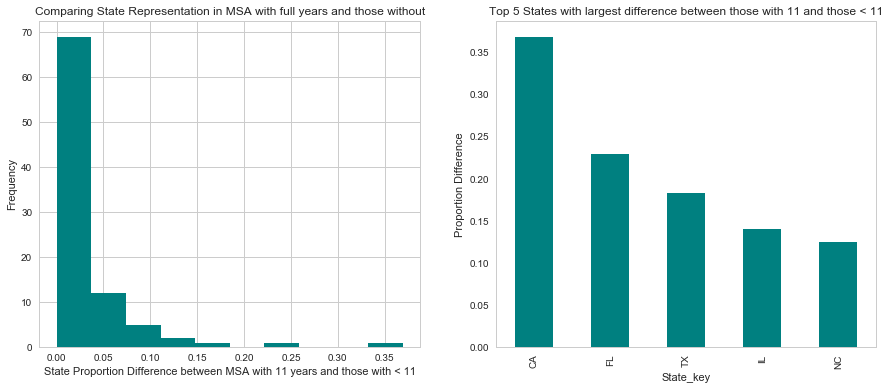

In [5]:
# Look at Differences by states
msa_11 =  final_df.loc[full_msa, ['city_key', 'state_key']].drop_duplicates()
msa_11_counts = msa_11.state_key.value_counts()
msa_11_pct  = pd.DataFrame(msa_11_counts / len(msa_11_counts))
msa_11_pct = msa_11_pct.rename(index=str, columns={'state_key': 'prop_11'})

msa_lt_11 =  final_df.loc[~full_msa, ['city_key', 'state_key']].drop_duplicates()
msa_lt_11_counts = msa_lt_11.state_key.value_counts()
msa_lt_pct = pd.DataFrame(msa_lt_11_counts / len(msa_lt_11_counts))
msa_lt_pct = msa_lt_pct.rename(index=str, columns={'state_key': 'prop_lt_11'})

compare = msa_11_pct.join(msa_lt_pct, how='outer')
compare.loc[compare.prop_11.isnull(), 'prop_11'] = 0
compare.loc[compare.prop_lt_11.isnull(), 'prop_lt_11'] = 0
compare['diff'] = abs(compare['prop_11'] - compare['prop_lt_11'])
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_xlabel("State Proportion Difference between MSA with 11 years and those with < 11")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Comparing State Representation in MSA with full years and those without")
ax[0].hist(compare['diff'], color='teal');

ax[1].set_xlabel("State_key")
ax[1].set_ylabel("Proportion Difference")
ax[1].set_title("Top 5 States with largest difference between those with 11 and those < 11")
ax[1] = compare.sort_values("diff", ascending=False).iloc[0:5, 2].plot(kind='bar', color='teal', grid=False)
#compare.head(100)

In [6]:
final_df = final_df.loc[full_msa, :]
del final_df['num_years']
#print(final_df.shape)
final_df.to_json('output/final_only11.json')

In [7]:
"""
Function
-------
x_y_scatter

This function plots a scatter plot between two variables with
certain stylings
"""
def x_y_scatter(x_var, y_var, x_label, y_label, title, ax):
    ax.scatter(x_var, y_var, color='teal', alpha=0.5)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14);

### Part 2. Data Exploration of Relevant Features###

In this section, we present the Exploratory Data Analysis (EDA) conducted to identify plausible relationships between number of murders and different MSA features.

### 1. MSA Population###

We could see a strong positive association between number of murders and population. In other words, **highly populated MSAs have higher number of murders.** 

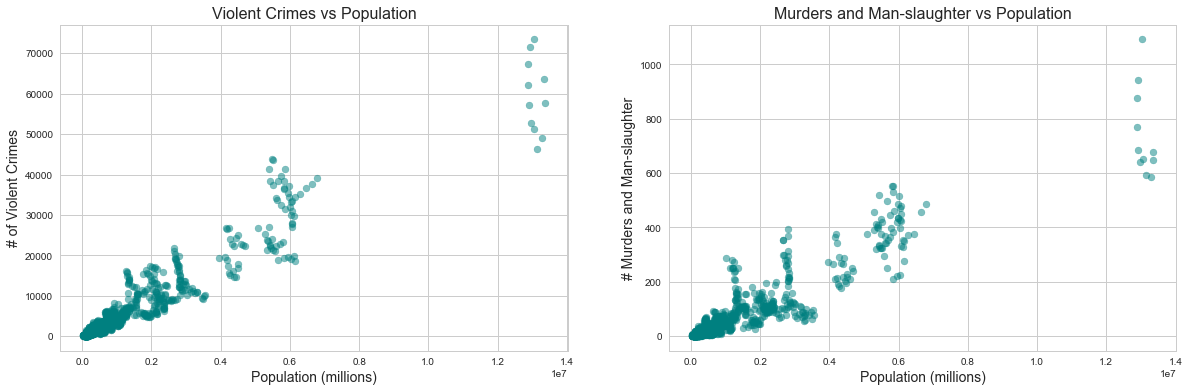

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

x_y_scatter(final_df['msa_pop'],
           final_df['violent_crime'],
           x_label='Population (millions)',
           y_label='# of Violent Crimes',
           title='Violent Crimes vs Population',
           ax=ax[0])

x_y_scatter(final_df['msa_pop'],
           final_df['mur_mans'],
           x_label='Population (millions)',
           y_label='# Murders and Man-slaughter',
           title='Murders and Man-slaughter vs Population',
           ax=ax[1])

### 2. Other Crimes###

MSAs with high counts for other violent crimes (such as rape, robbery and aggravated assault) tend to have a high murder count


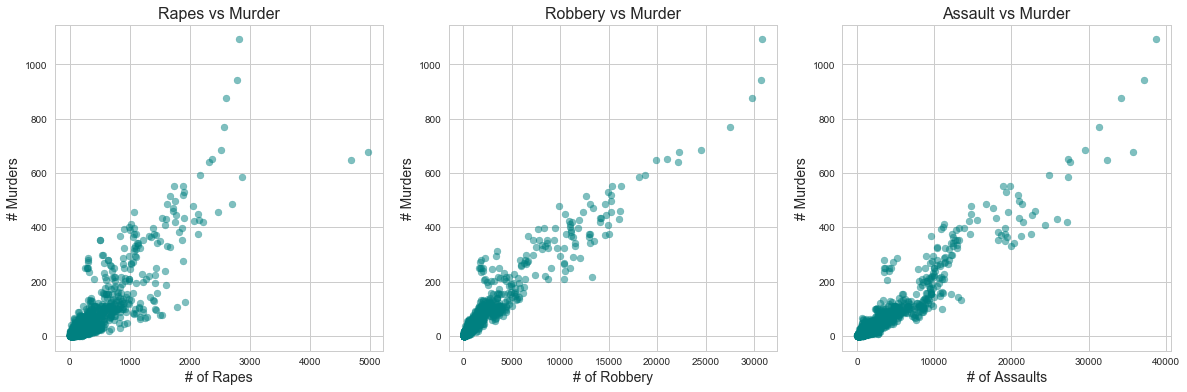

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,3,figsize=(20,6))

# Rape
x_y_scatter(final_df['rape'],
           final_df['mur_mans'],
           x_label='# of Rapes',
           y_label='# Murders',
           title='Rapes vs Murder',
           ax=ax[0])

# Robbery
x_y_scatter(final_df['robbery'],
           final_df['mur_mans'],
           x_label='# of Robbery',
           y_label='# Murders',
           title='Robbery vs Murder',
           ax=ax[1])
# Assault
x_y_scatter(final_df['assault'],
           final_df['mur_mans'],
           x_label='# of Assaults',
           y_label='# Murders',
           title='Assault vs Murder',
           ax=ax[2])

label_size = 13
matplotlib.rcParams['xtick.labelsize'] = label_size
plt.savefig('Murder Other crimes', bbox_inches='tight')

### 3. Gini Index###

Gini Index is a measure of economic inequality within an MSA and we observed a strong pattern for cases where annual mruder count is greater than 200.

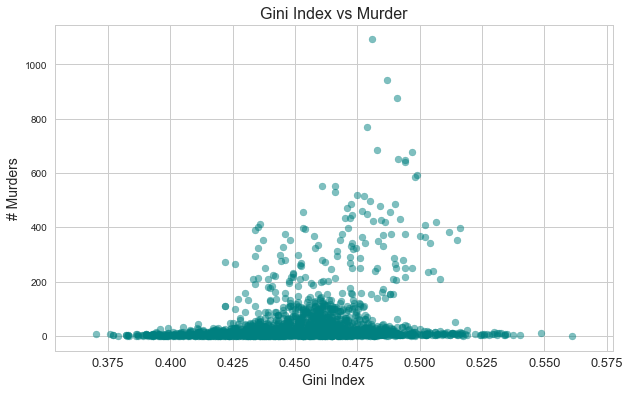

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
x_y_scatter(final_df['gini'],
           final_df['mur_mans'],
           x_label='Gini Index',
           y_label='# Murders',
           title='Gini Index vs Murder',
           ax=ax)

### 4. Remaining Fields###

We examined all the remaining features against number of murders and could not find a strong correlation. The scatter plots reflect the distribution of the features in the data set.

*Note: We are presenting only the most relevant findings here. Thorough examination of all the features against response was performed in detail.Additional examples and plots are included in the notebook*

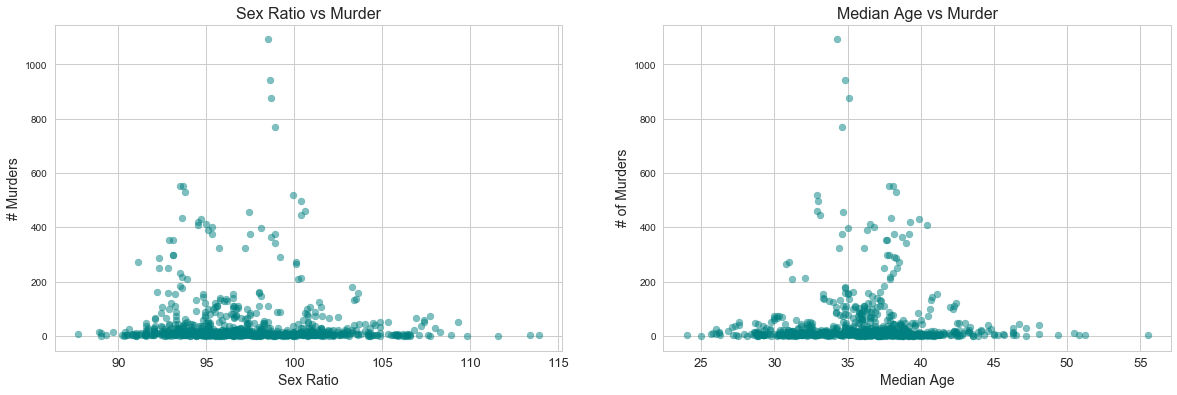

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
x_y_scatter(final_df['sex_ratio'],
           final_df['mur_mans'],
           x_label='Sex Ratio',
           y_label='# Murders',
           title='Sex Ratio vs Murder',
           ax=ax[0])
x_y_scatter(final_df['median_age'],
           final_df['mur_mans'],
           x_label='Median Age',
           y_label='# of Murders',
           title='Median Age vs Murder',
           ax=ax[1])

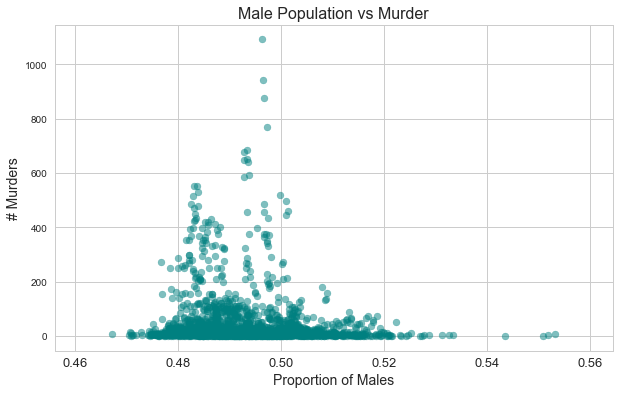

In [12]:

fig, ax = plt.subplots(1,1,figsize=(10,6))
x_y_scatter(final_df['male_pop'],
           final_df['mur_mans'],
           x_label='Proportion of Males',
           y_label='# Murders',
           title='Male Population vs Murder',
           ax=ax)



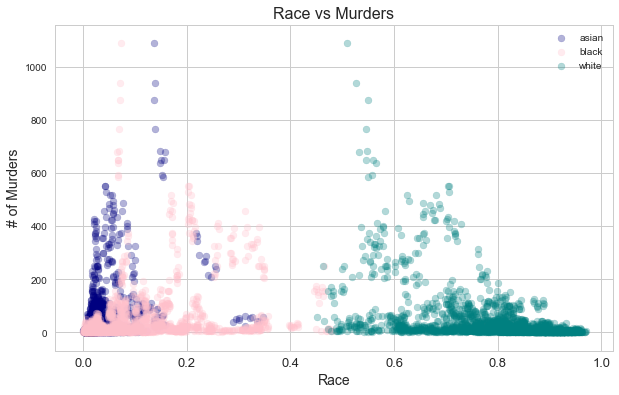

In [13]:

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(final_df['asian'], final_df['mur_mans'], color='navy', alpha=0.3, label='asian')
ax.scatter(final_df['black'], final_df['mur_mans'], color='pink', alpha=0.3, label='black')
ax.scatter(final_df['white'], final_df['mur_mans'], color='teal', alpha=0.3, label='white')
ax.set_title('Race vs Murders', fontsize=16)
ax.set_xlabel('Race', fontsize=14)
ax.set_ylabel('# of Murders', fontsize=14)
ax.legend();




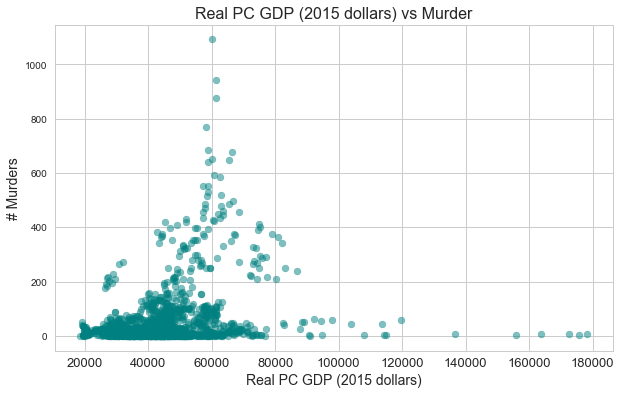

In [14]:

fig, ax = plt.subplots(1,1,figsize=(10,6))
x_y_scatter(final_df['real_pc_gdp'],
           final_df['mur_mans'],
           x_label='Real PC GDP (2015 dollars)',
           y_label='# Murders',
           title='Real PC GDP (2015 dollars) vs Murder',
           ax=ax)


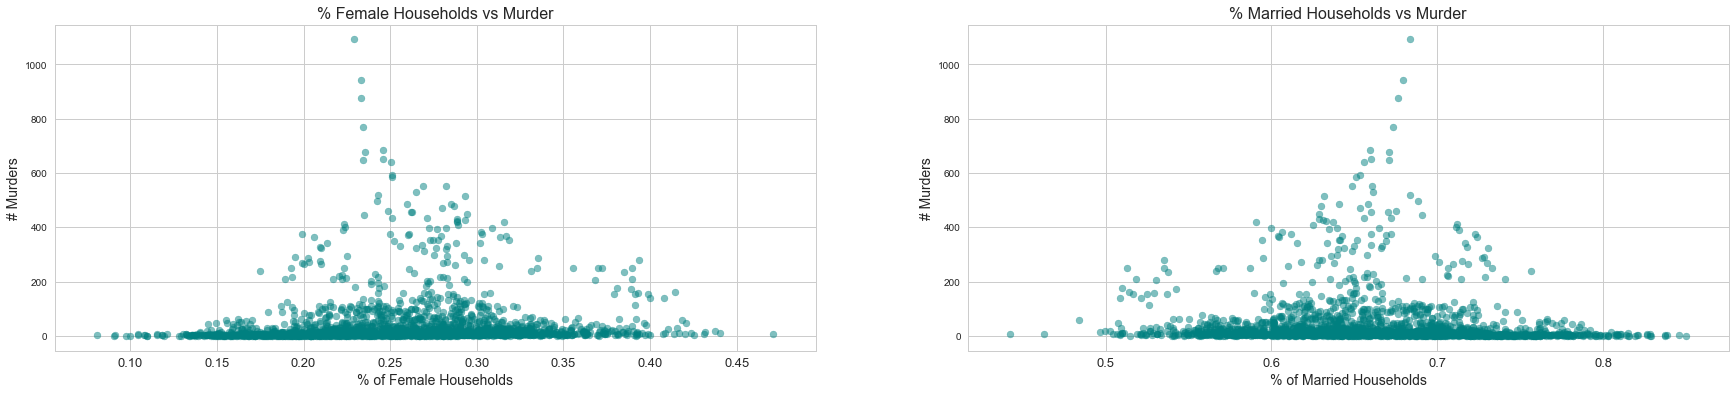

In [15]:

fig, ax = plt.subplots(1, 2, figsize=(30,6))
x_y_scatter(final_df['female_house'],
           final_df['mur_mans'],
           x_label='% of Female Households',
           y_label='# Murders',
           title='% Female Households vs Murder',
           ax=ax[0])

x_y_scatter(final_df['married_house'],
           final_df['mur_mans'],
           x_label='% of Married Households',
           y_label='# Murders',
           title='% Married Households vs Murder',
           ax=ax[1])



In [16]:
'''
Function
----------
scatter_list_murder

This function takes a list of variables and plots each one vs murder

Parameter list:
    var_list - list of strings to plot
    nrows - # of rows in the grid
    ncols - # of cols in grid
    figsize- tuple for figsize

'''
def scatter_list_murder(var_list, nrows, ncols, figsize, log_trans=False):
    fig, ax = plt.subplots(nrows,ncols,figsize=figsize)
    ax = ax.flatten()
    for i, v in enumerate(var_list):
        if log_trans:
            var = np.log(final_df[v])
            label= "Log(" + v + ")"
        else:
            var = final_df[v]
            label = v
            
        
        x_y_scatter(var,
               final_df['mur_mans'],
               x_label=label,
               y_label='# Murders',
               title='%s vs Murder' %v,
               ax=ax[i])
    fig.tight_layout();

### Unemployment Rate

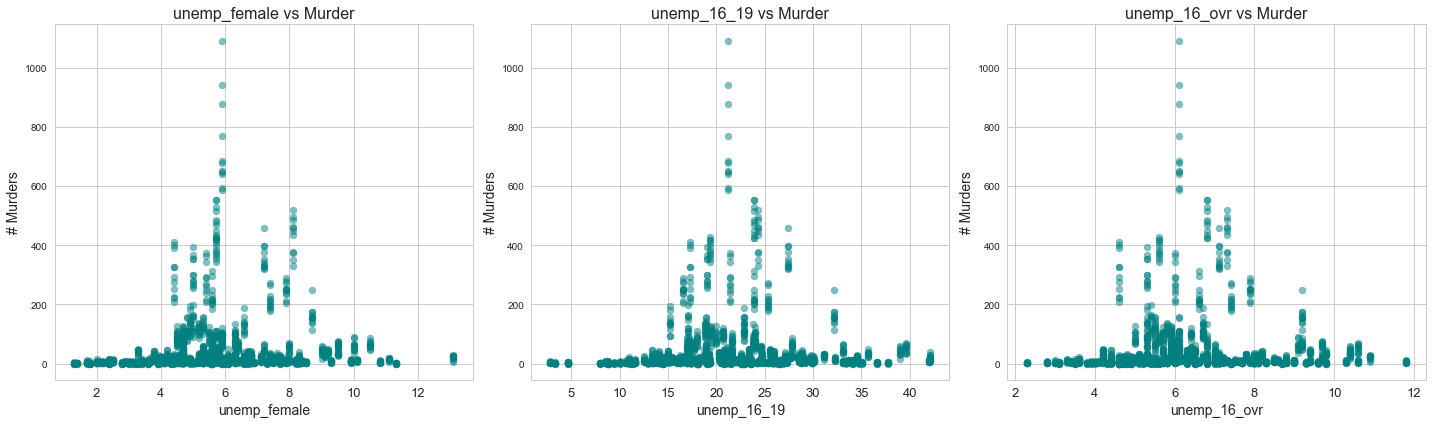

In [17]:

### Unemployment Rate
scatter_list_murder(['unemp_female', 'unemp_16_19', 'unemp_16_ovr'],
                    1,3, (20,6))



### Education

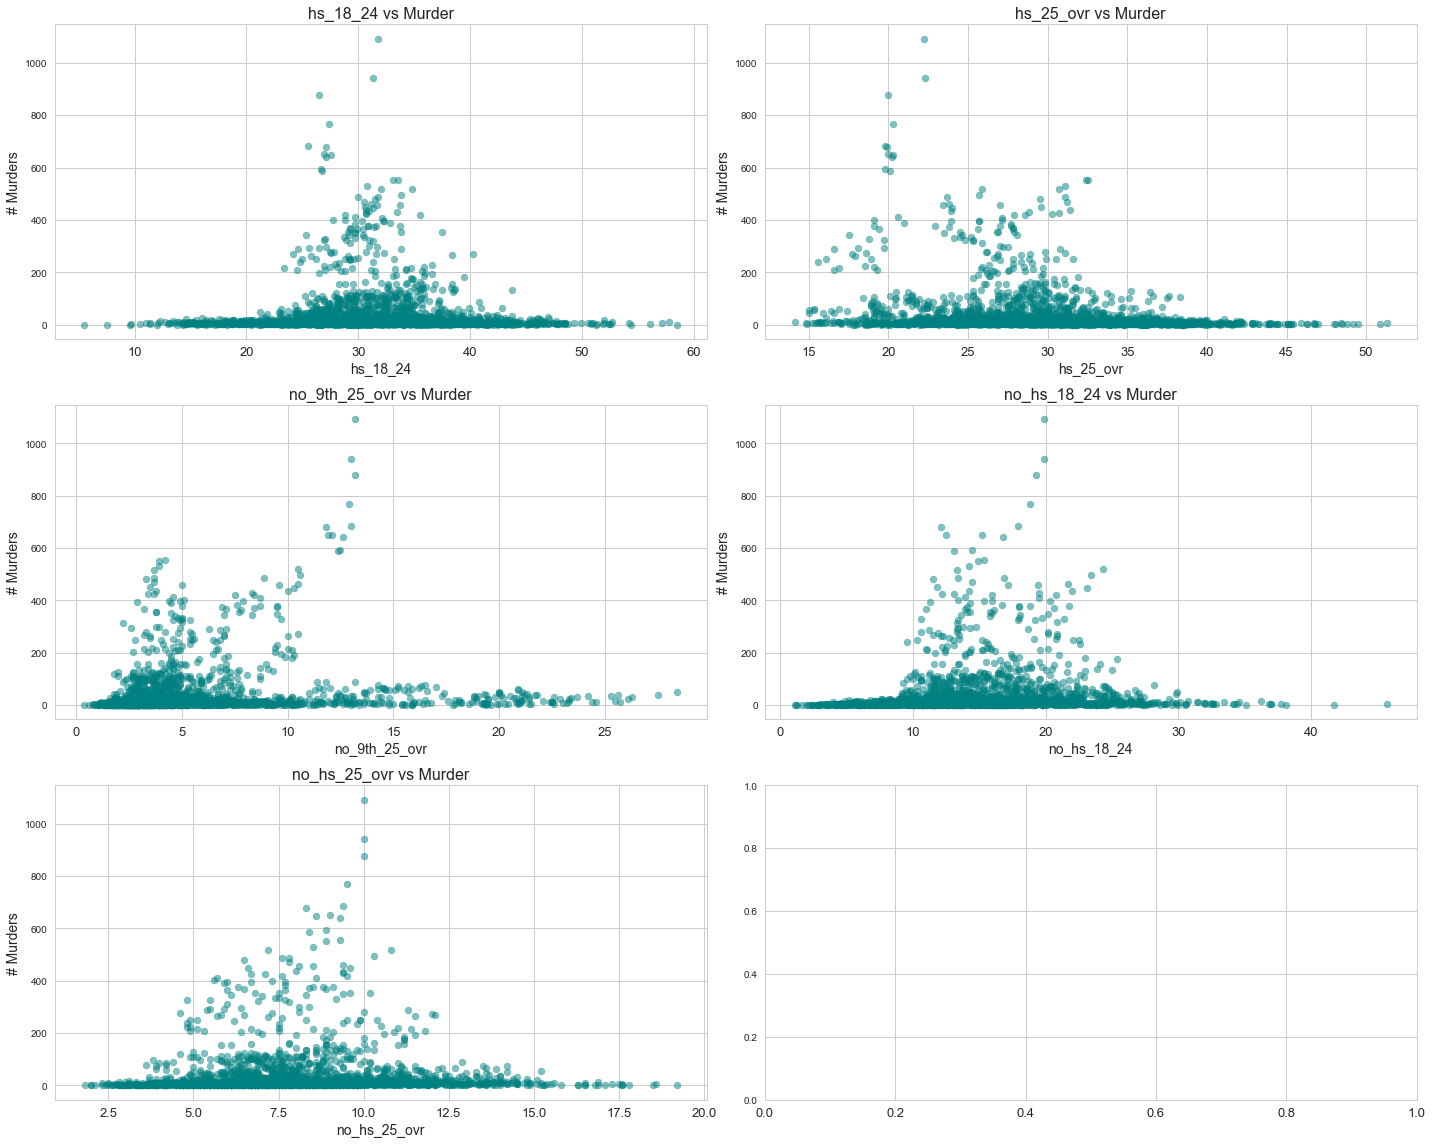

In [18]:

scatter_list_murder(['hs_18_24', 'hs_25_ovr', 'no_9th_25_ovr', 
                     'no_hs_18_24', 'no_hs_25_ovr'],
                    3, 2, (20, 16))



### Poverty

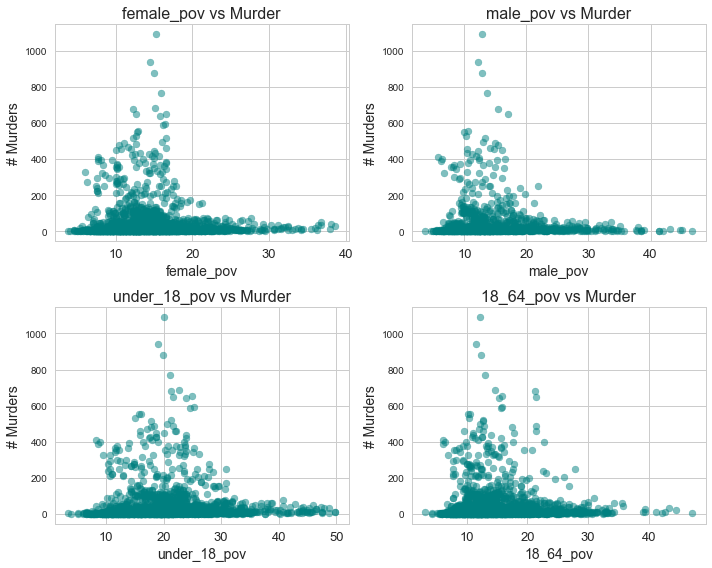

In [19]:


scatter_list_murder(['female_pov', 'male_pov', 'under_18_pov', '18_64_pov'],
                    2, 2, (10, 8), log_trans=False)


### Part 3. Murder Rate Evaluation by MSA, State and Year###

**MSA**

Upon examining the average crime rate across all years for all MSAs, we discovered that **New Orleans, LA** has the highest crime rate.

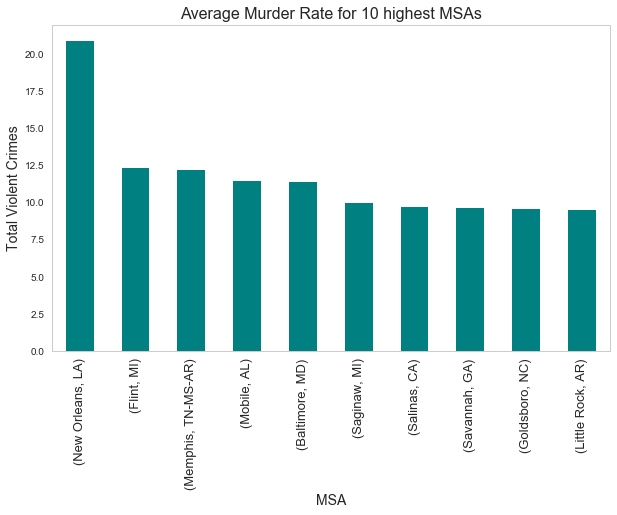

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = final_df.groupby(['city_key', 'state_key'])['rate_mur_mans'].mean().sort_values(
    ascending=False).iloc[0:10].plot(kind='bar', color='teal', grid=False)
ax.set_title('Average Murder Rate for 10 highest MSAs', fontsize=16)
ax.set_xlabel('MSA', fontsize=14)
ax.set_ylabel('Total Violent Crimes',fontsize=14);

**State**

**California** has the highest average crime rate across all 11 years.

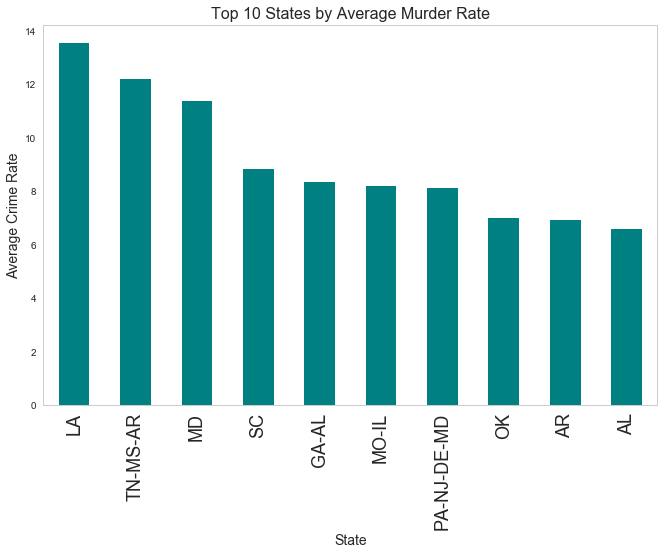

In [21]:
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax=final_df.groupby('state_key')['rate_mur_mans'].mean().sort_values(
    ascending=False).iloc[0:10].plot(kind='bar',grid=False, color='teal')
ax.set_title('Top 10 States by Average Murder Rate', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Average Crime Rate',fontsize=14)
plt.savefig('State_vs_Avg_Crime_rate', bbox_inches='tight')

**Years**

On an average, all years seem to have a consistent crime rate. Interesting there is not an temporal increasing trend

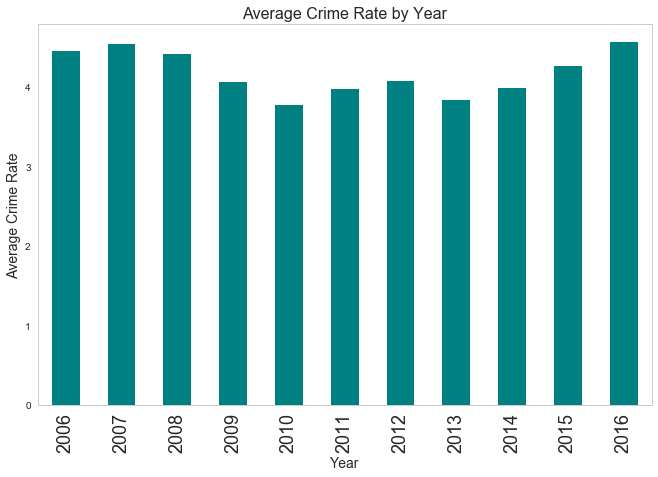

In [22]:
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax=final_df.sort_values("year").groupby('year')['rate_mur_mans'].mean().plot(kind='bar',grid=False, color='teal')
ax.set_title('Average Crime Rate by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Crime Rate',fontsize=14);